In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots
import os

plt.style.use(['science', 'grid'])
plt.rc('figure', titlesize = 33, figsize = (21, 7), dpi = 210)
plt.rc('axes', titlesize = 27, labelsize = 21, titlepad = 21)
plt.rc('xtick', labelsize = 17)
plt.rc('ytick', labelsize = 17)

In [2]:
data = pd.read_csv('/Users/fomo/Documents/Kaizen/code/physionet/data/CG Macros/bio_x_gut.csv')

data.head()

,subject,age,gender,bmi,body_weight,height,a1c,fasting_glu,insulin,triglycerides,...,inflammatory_activity,gut_microbiome_health,digestive_efficiency,protein_fermentation,gas_production,methane_gas_production_pathways,sulfide_gas_production_pathways,oxalate_metabolism_pathways,salt_stress_pathways,microbiome-induced_stress
0,1,27,True,22.265239,133.8,65.0,5.4,91,2.5,67,...,2,3,1,1,2,3,1,1,3,2
1,2,49,False,30.946742,169.2,62.0,5.5,93,14.8,61,...,2,2,1,1,1,1,1,3,2,1
2,3,59,False,26.948690,157.0,64.0,6.5,118,17.4,154,...,2,2,2,1,2,3,2,1,3,2
3,4,33,False,42.384279,262.6,66.0,5.5,105,19.4,300,...,2,1,2,1,3,3,3,1,2,2
4,5,51,False,30.957534,172.0,62.5,6.6,144,12.9,392,...,1,1,2,2,3,3,2,2,2,2


<Axes: >

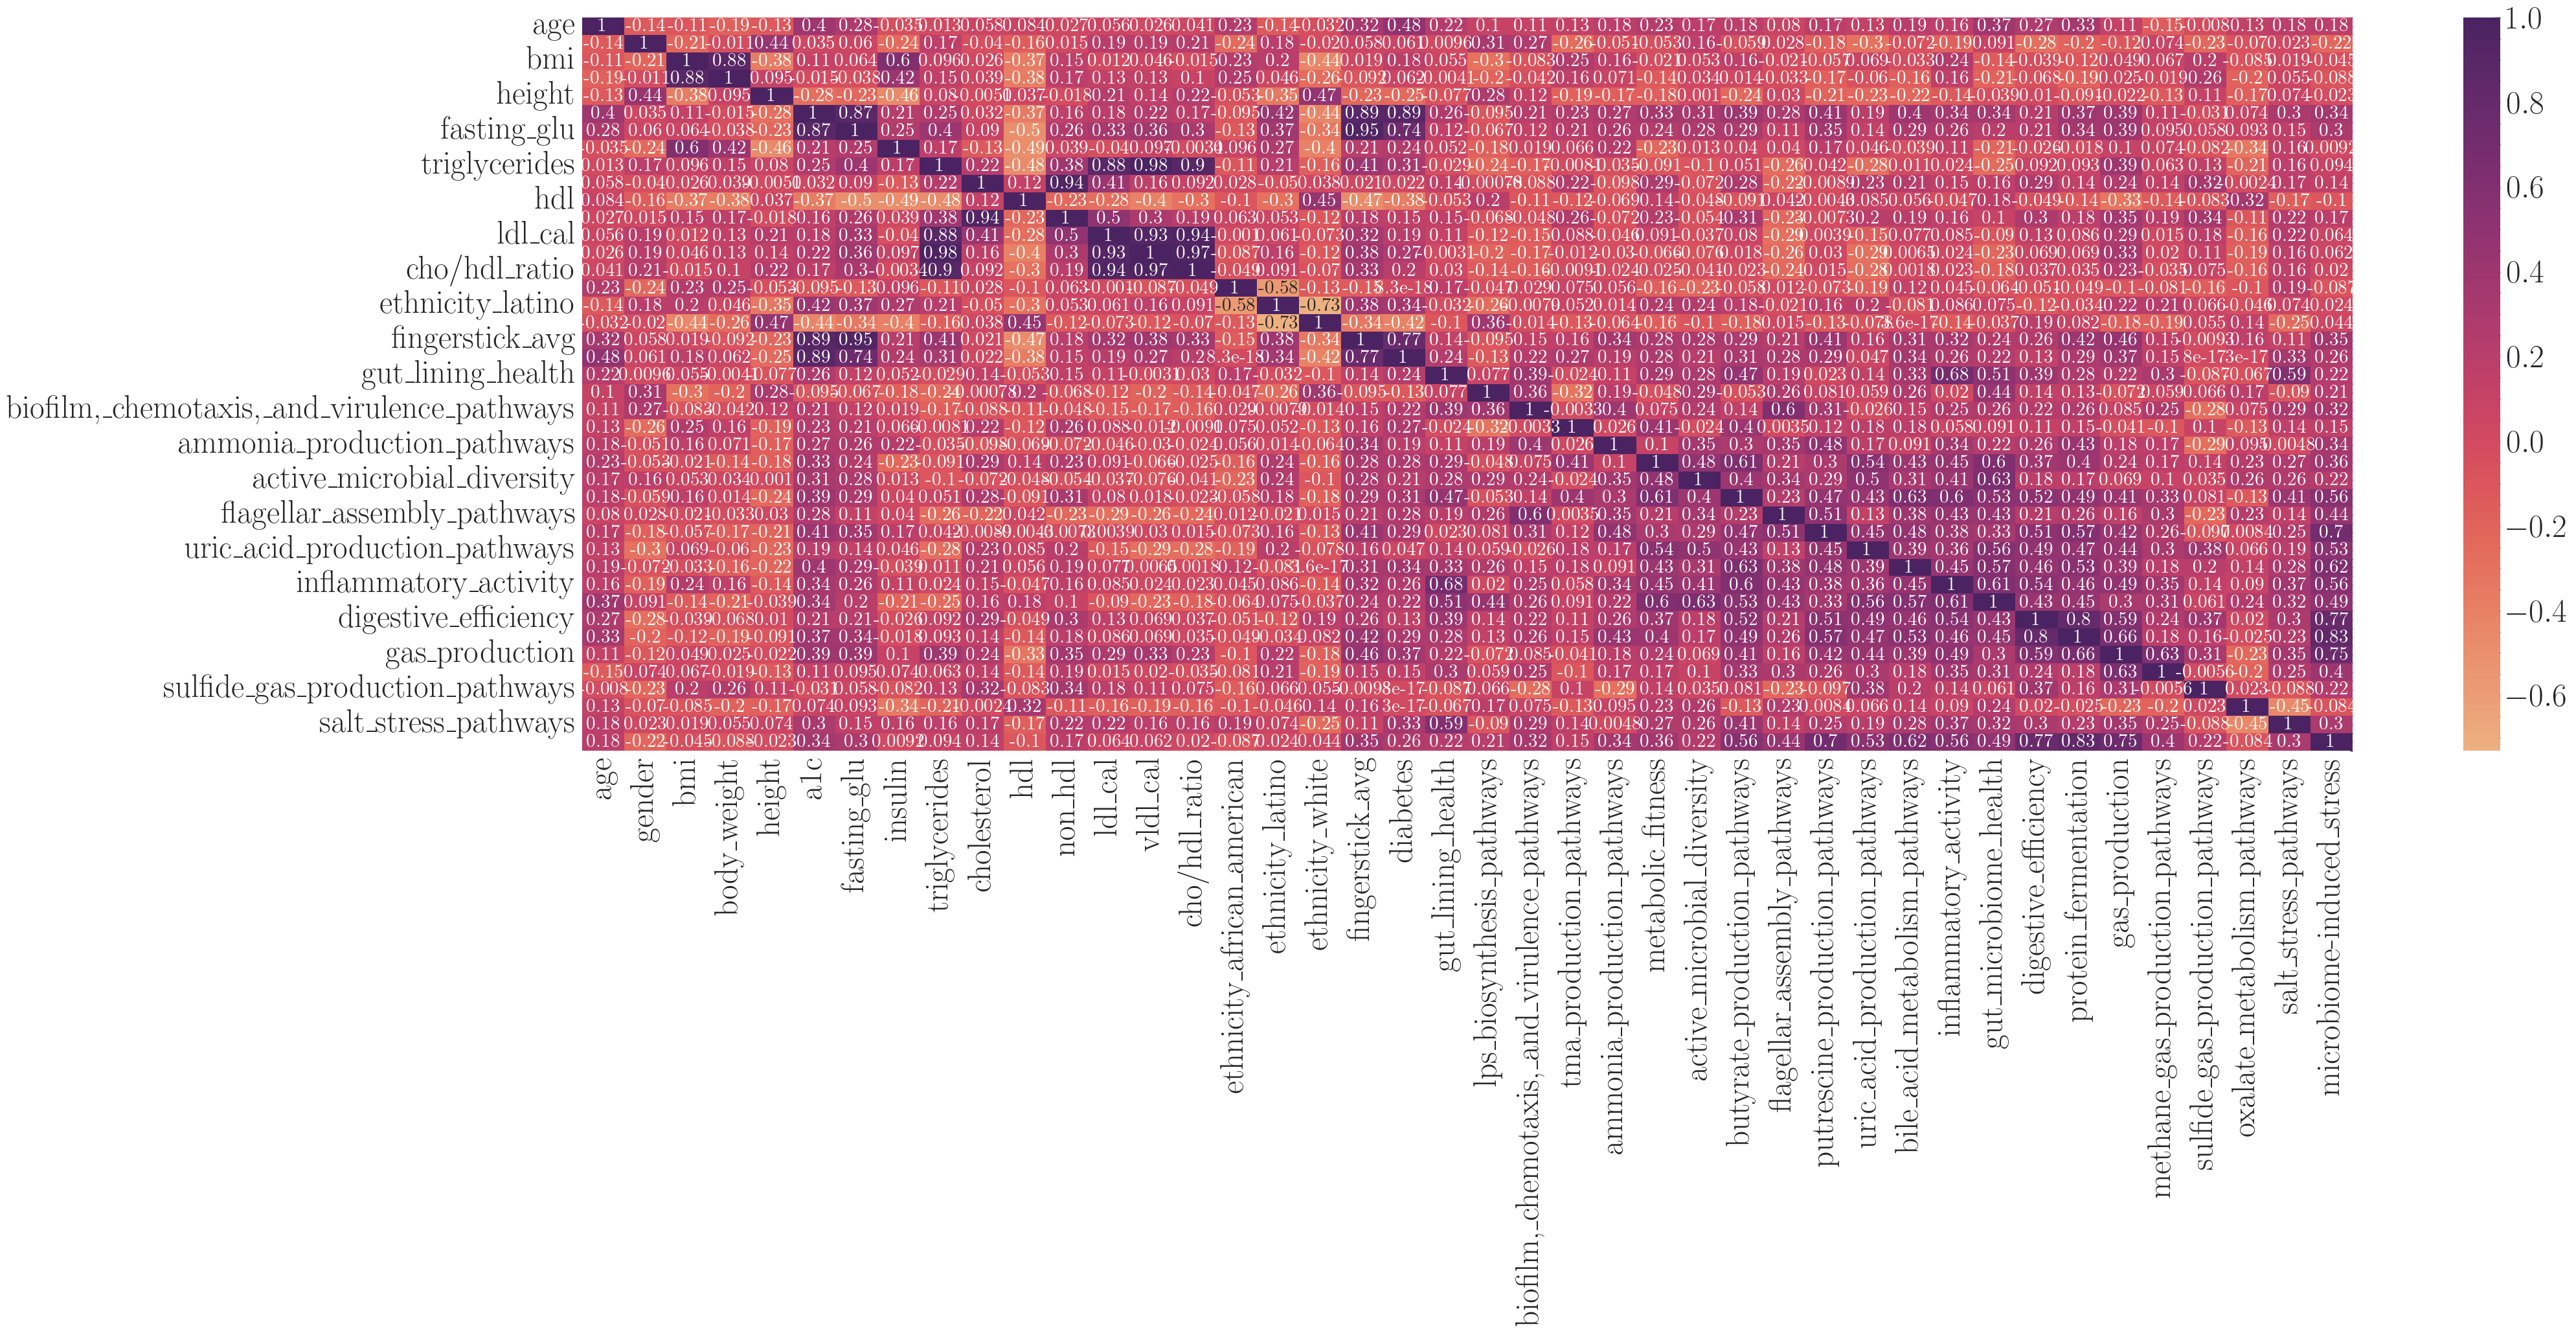

In [36]:
select = data.drop(['subject'], axis = 1)

sns.heatmap(select.corr(), annot = True, cmap = 'flare')

# Data Preprocessing

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

X = data.drop(['diabetes', 'subject'], axis = 1)
y = data['diabetes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train.shape, X_test.shape

((33, 41), (9, 41))

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV

# parameter grid for hyperparameter tuning
param_grid = {
    "C": [0.01, 0.1, 1, 10, 100],  # Regularization strength
    "solver": ["lbfgs", "newton-cg", "saga"],  # Different solvers for multinomial classification
    "max_iter": [200, 500, 1000]  # Number of iterations for convergence
}


# define logistic regression model with softmax for multiclass
model = LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=500)

# RandomizedSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(
    model, 
    param_distributions=param_grid, 
    n_iter=5, 
    cv=5, 
    random_state=343
)


random_search.fit(X_train, y_train)  
best_reg = random_search.best_estimator_
y_pred = best_reg.predict(X_test)

print('Best Parameters:', random_search.best_params_)
print(classification_report(y_test, y_pred, target_names=['healthy', 'prediabetes', 'diabetes']))

Best Parameters: {'solver': 'saga', 'max_iter': 1000, 'C': 0.01}
              precision    recall  f1-score   support

     healthy       1.00      1.00      1.00         2
 prediabetes       0.17      1.00      0.29         1
    diabetes       1.00      0.17      0.29         6

    accuracy                           0.44         9
   macro avg       0.72      0.72      0.52         9
weighted avg       0.91      0.44      0.44         9



/Users/fomo/anaconda3/envs/spectra/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/fomo/anaconda3/envs/spectra/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/fomo/anaconda3/envs/spectra/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/fomo/anaconda3/envs/spectra/lib/python3.9/site-packages/sklearn/linea

In [23]:
from xgboost import XGBClassifier

param_grid = {
    "n_estimators": [50, 100, 150, 200],
    "max_depth": [3, 4, 5, 6, 7],
    "learning_rate": [0.01, 0.1, 0.3, 0.5, 0.7, 1]
}

model = XGBClassifier()

random_search_xgb = RandomizedSearchCV(
    model, 
    param_distributions=param_grid, 
    n_iter=5, 
    cv=5, 
    random_state=21
)

random_search_xgb.fit(X_train, y_train)
best_xgb = random_search_xgb.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)

print('Best Parameters:', random_search_xgb.best_params_)
print(classification_report(y_test, y_pred_xgb, target_names=['healthy', 'prediabetes', 'diabetes']))

Best Parameters: {'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.7}
              precision    recall  f1-score   support

     healthy       1.00      1.00      1.00         2
 prediabetes       0.50      1.00      0.67         1
    diabetes       1.00      0.83      0.91         6

    accuracy                           0.89         9
   macro avg       0.83      0.94      0.86         9
weighted avg       0.94      0.89      0.90         9



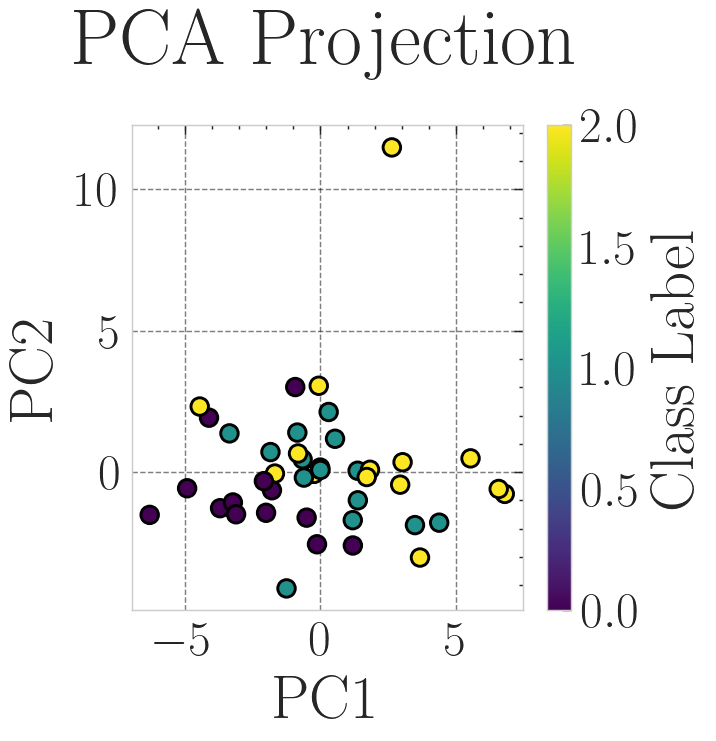

In [32]:
from sklearn.decomposition import PCA

# standardize the features
pca_scaler = StandardScaler()
X_scaled = pca_scaler.fit_transform(X)

# apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# scatter plot
fig = plt.figure(figsize=(3, 3), dpi=210)

# 2D
ax = fig.add_subplot(111)
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', edgecolors='k')


# 3D
# ax = fig.add_subplot(111, projection='3d')
# scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y, cmap='viridis', edgecolors='k')

# Add color bar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label("Class Label")

# Labels and title
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
# ax.set_zlabel("PC3")
ax.set_title("PCA Projection")

plt.show()
